#  Predicting bodyfat levels from body measurements

## Imports

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor



## Background: From Kaggle: 

#### Data imports, memory usage, and data inspection

In [91]:
df = pd.read_csv('/Users/michaelschaid/GitHub/BF_prediciton/data/bodyfat.csv')

total_mem = df.memory_usage(deep=True).sum()
print(f'total memory usage: {total_mem/ 1024**2} MB \n')
print(df.dtypes)
df.head()

total memory usage: 0.028961181640625 MB 

Density    float64
BodyFat    float64
Age          int64
Weight     float64
Height     float64
Neck       float64
Chest      float64
Abdomen    float64
Hip        float64
Thigh      float64
Knee       float64
Ankle      float64
Biceps     float64
Forearm    float64
Wrist      float64
dtype: object


,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


Data cleaning
* convert weight to KG, 
* calculate BMI and chest to abdominal, ratio. 
* weight and height are repetitive and add to colinearity, so we dropped them

In [92]:
def feat_eng(df):
    return (df
            .rename(lambda c: c.lower(), axis=1)
            .assign(weight = lambda df: df.weight * 0.45359237, 
                    bmi = lambda df: df.weight / (df.height**2), 
                    chest_abd_ratio = lambda df: df.chest / df.abdomen
                        )
            .drop(columns = ['height', 'weight'])
    )
    
data = feat_eng(df)
data.head()

,density,bodyfat,age,neck,chest,abdomen,hip,thigh,knee,ankle,biceps,forearm,wrist,bmi,chest_abd_ratio
0,1.0708,12.3,23,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,0.015243,1.092723
1,1.0853,6.1,22,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,0.015054,1.127711
2,1.0414,25.3,22,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,0.015915,1.089875
3,1.0751,10.4,26,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,0.016054,1.178241
4,1.0340,28.7,24,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,0.016463,0.973000


#### split data into train and test sets

In [93]:

X = data.drop(columns= ['bodyfat'])
y = data['bodyfat']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### Initial Linear Regression fitting and training

In [94]:
def train_and_score(X_train, X_test, y_train, y_test):
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    lr.predict(X_test) 
    mse = mean_squared_error(y_test,lr.predict(X_test))
    return mse
train_and_score(X_train, X_test, y_train, y_test)

0.2714244318237317

## Model Experimentation
* Linear Regresssion
* Gradient boosted regression
* K-means clustering

In [95]:
def define_model(name: str, estimator: object, params:dict = None):
    return {'name': name,
            'estimator': estimator,
            'hyperparameters': params}

logistic_regression = define_model('logistic_regression',
                                   LinearRegression(),
                                   params = 
                                   {
                                       'n_jobs': [10, 30], 
                                        'fit_intercept': [True, False]
                                       }
                                   )

gradient_boosting = define_model('gradient_boosting',
                                 GradientBoostingRegressor(),
                                 params  = 
                                 {
                                     'loss':['squared_error', 'absolute_error', 'huber', 'quantile'], 
                                     'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5], 
                                     'n_estimators':[100, 200, 300, 400, 500]
                                 }
                                 )


def grid_search(df, features, target, model):
    grid  = GridSearchCV(estimator = model['estimator'], param_grid = model['hyperparameters'], cv = 10)
    grid.fit(X,y)
    model['best_estimator'] = grid.best_params_
    model['best_score'] = grid.best_score_
    model['best_model'] = grid.best_estimator_
    
    

In [88]:
models  =  [logistic_regression, gradient_boosting, k_means]

for model in models:
    grid_search(df = data, features = X, target = y, model = model)

/Users/michaelschaid/opt/anaconda3/envs/bodyfat/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/michaelschaid/opt/anaconda3/envs/bodyfat/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/michaelschaid/opt/anaconda3/envs/bodyfat/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/michaelschaid/opt/anaconda3/envs/bodyfat/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4

In [98]:
models

[{'name': 'logistic_regression',
  'estimator': LinearRegression(),
  'hyperparameters': {'n_jobs': [10, 30], 'fit_intercept': [True, False]},
  'best_estimator': {'fit_intercept': True, 'n_jobs': 10},
  'best_score': 0.9606501784310402,
  'best_model': LinearRegression(n_jobs=10)},
 {'name': 'gradient_boosting',
  'estimator': GradientBoostingRegressor(),
  'hyperparameters': {'loss': ['squared_error',
    'absolute_error',
    'huber',
    'quantile'],
   'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
   'n_estimators': [100, 200, 300, 400, 500]},
  'best_estimator': {'learning_rate': 0.1,
   'loss': 'absolute_error',
   'n_estimators': 400},
  'best_score': 0.9637663544326032,
  'best_model': GradientBoostingRegressor(loss='absolute_error', n_estimators=400)},
 {'name': 'k_means',
  'estimator': KMeans(),
  'hyperparameters': {'n_clusters': [2, 4, 6, 8, 10],
   'max_iter': [100, 200, 300, 400, 500],
   'algorithm': ['lloyd', 'auto', 'full', 'elkan']},
  'best_estimator': {'algorithm': 

In [101]:
def test_estimators(estimators):
    gb = GradientBoostingRegressor(n_estimators=estimators, 
                                   learning_rate=0.1, 
                                   loss='absolute_error')
    gb.fit(X_train, y_train)
    gb.predict(X_test)
    score = gb.score(X_test, y_test)
    return score
    

estimate = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
scores = [test_estimators(estimators) for estimators in estimate]

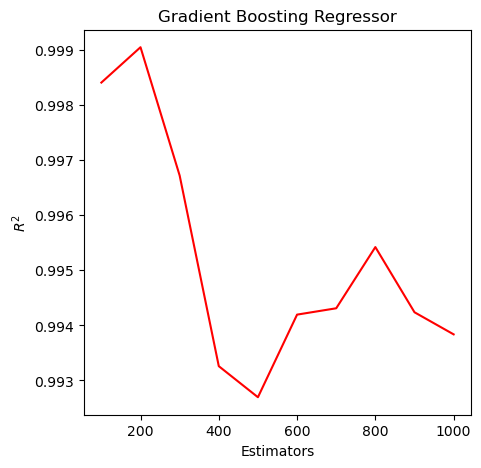

In [126]:
def plot_experiment(x,y, x_label, y_label):
    
    fig, ax = plt.subplots(figsize=(5,5))

    sns.lineplot(x=x, y=y, color = 'red', ax = ax)
    params = {
            'title': 'Gradient Boosting Regressor',
            'ylabel': y_label,
            'xlabel': x_label
            }

    ax.set(**params)

    plt.show()

    
plot_experiment(estimate, scores, 'Estimators', '$R^2$')


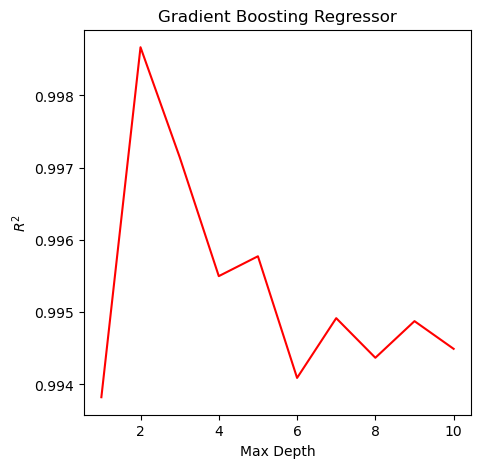

In [127]:
def test_max_depth(max_depth):
    gb = GradientBoostingRegressor(n_estimators=100, 
                                   learning_rate=0.1, 
                                   max_depth=max_depth,
                                   loss='absolute_error')
    gb.fit(X_train, y_train)
    gb.predict(X_test)
    score = gb.score(X_test, y_test)
    return score

depth = [1,2,3,4,5,6,7,8,9,10]
depth_scores = [test_max_depth(max_depth) for max_depth in depth]

plot_experiment(depth, depth_scores, 'Max Depth', '$R^2$')

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Results:
*****
We are able to achieve a an $R^2$ score of near .99 with the following model:

Gradient boosting regressor
params:
    learning_rate: 0.1
    n_estimators: 100
    max_depth:3

